# Part 0 Problem Background


> Amazon offers its prime members free access to Prime Video and recommends certain videos to users based on various features. In this analytics project, the goal is to find out what kinds of movies are more popular on Amazon Prime Video and predict how popular a video would be, measured by cumulated view time per day(Cvt_per_day).   




# Part 1 Data Loading

In [1]:
#import neccessary libraries
import numpy as np
import pandas as pd
import sklearn as sl
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1hI40okExQduWHxtbfO2hVLBt_8_mLtOq'
_, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('TVdata.txt') 

In [4]:
video = pd.read_csv('TVdata.txt',header = 0,sep = ',',lineterminator = '\n')
video.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
1,300175,270338.426,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.500,94.983,41,no award,R,3.250
2,361899,256165.867,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.300,115.764,58,other award,R,2.647
3,308314,196622.721,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.600,130.704,94,Oscar,R,1.667
4,307201,159841.652,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.400,105.546,37,other award,R,3.067


In [5]:
video.columns

Index(['video_id', 'cvt_per_day', 'weighted_categorical_position',
       'weighted_horizontal_poition', 'import_id', 'release_year', 'genres',
       'imdb_votes', 'budget', 'boxoffice', 'imdb_rating', 'duration_in_mins',
       'metacritic_score', 'awards', 'mpaa', 'star_category'],
      dtype='object')

In [6]:
video.shape

(4226, 16)

### Data Set Description
There are total 4,226 rows and 16 columns in the dataset. Detailed descriptions are as follows:

Prime Video Data | Description
--- | ---
video_id	|A unique id for a movie.
cvt_per_day	|Cumulated view time per day
weighted_categorical_position |	Average vertical positions on the home page that the movie was placed
weighted_horizontal_position |	Average horizontal positions on the home page that the movie was placed
import_id |	Content partners
release_year |	Year when the movie was released
genres | Genres of the movie
imdb_votes | The number of votes on IMDB
budget | Movie production budget
boxoffice | Gross box office in the US according to IMDB 
imdb_rating | Ratings on IMDB
duration_in_mins | How long is the content in minutes
metacritic_score | Metacritic score on IMDB page(hight the better)
awards | TVPG ratings 
mpaa | MPAA ratings 
star_category | A score to measure how popular the casting members  are 

# Part 2 Exploratory Analysis

## 2.1 Missing Value Detection

In [7]:
#check missing values
video.isnull().sum()

video_id                         0
cvt_per_day                      0
weighted_categorical_position    0
weighted_horizontal_poition      0
import_id                        0
release_year                     0
genres                           0
imdb_votes                       0
budget                           0
boxoffice                        0
imdb_rating                      0
duration_in_mins                 0
metacritic_score                 0
awards                           0
mpaa                             0
star_category                    0
dtype: int64

In [8]:
# statistics summary on numerical features
video.drop(columns = ['video_id','release_year']).describe()

,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
count,4226.000,4226.000,4226.000,4226.000,4226.000,4226.000,4226.000,4226.000,4226.000,4226.000
mean,4218.630,7.783,28.104,6462.924,2150743.439,2536338.472,5.257,89.556,15.974,0.955
std,13036.080,6.134,11.864,31596.007,7176604.483,8243516.266,2.123,21.086,26.205,0.955
min,2.188,1.000,1.000,0.000,0.000,0.000,0.000,4.037,0.000,0.000
25%,351.169,4.000,20.000,81.000,0.000,0.000,4.300,82.602,0.000,0.000
50%,1193.500,6.000,28.000,535.000,0.000,0.000,5.800,90.730,0.000,1.000
75%,3356.789,9.000,36.000,3053.000,1500000.000,0.000,6.800,99.500,41.000,1.667
max,307127.606,41.000,70.000,948630.000,107000000.000,184208848.000,10.000,246.017,100.000,4.000


In [9]:
zero_percent = pd.Series((video == 0).sum(axis = 0)/video.shape[0])
zero_percent.sort_values(ascending = True)

video_id                        0.000
cvt_per_day                     0.000
weighted_categorical_position   0.000
weighted_horizontal_poition     0.000
import_id                       0.000
release_year                    0.000
genres                          0.000
duration_in_mins                0.000
awards                          0.000
mpaa                            0.000
imdb_votes                      0.081
imdb_rating                     0.081
star_category                   0.437
budget                          0.581
metacritic_score                0.713
boxoffice                       0.756
dtype: float64

  From the statistics summary, we can conclude that there are some abnormalities in budget, boxoffice,metacritic_score and star_category, which around 50% or more are ZEROs.Against the common sense, it could be due to the missing values during data collection phase.

## 2.2 Distribution of Target Variable

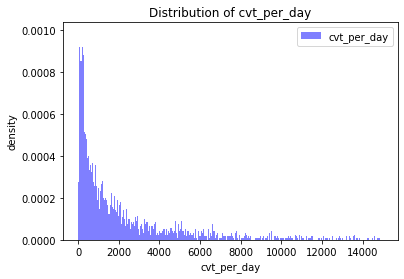

In [10]:

plt.hist(video['cvt_per_day'],bins=range(0,15000,30),color='b',label='cvt_per_day',density=True,alpha=0.5)
plt.title('Distribution of cvt_per_day')
plt.legend(loc='upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

## 2.3 Correlation among numerical features

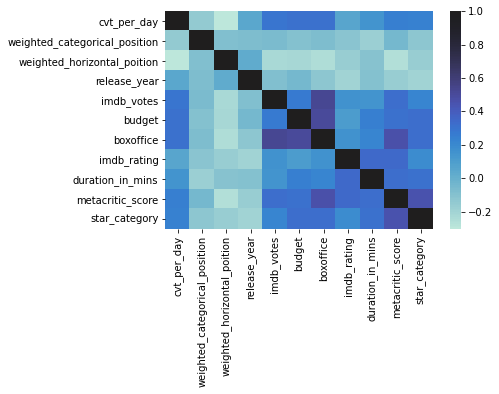

In [11]:
# correlation 
numerical_cols = video.drop(columns='video_id',).select_dtypes([np.number])
corr_score = numerical_cols.corr()
sns.heatmap(corr_score,robust=False, center=1)

Intuitively, heatmaps tell us the linear relationship between pair-wise features, darker the color, higher the correlation.For example, cvt_per_day is more closely related to budget, boxoffice and imdb_votes than other features. Also, these three features are highly correlated to each other as well.

## 2.4 Understand the categorical features

no award       0.608
other award    0.344
Oscar          0.033
Golden Globe   0.010
BAFTA          0.004
Name: awards, dtype: float64
NotRated   0.511
R          0.274
PG-13      0.101
PG         0.084
G          0.030
NC-17      0.001
Name: mpaa, dtype: float64
other       0.701
lionsgate   0.160
mgm         0.105
paramount   0.033
Name: import_id, dtype: float64


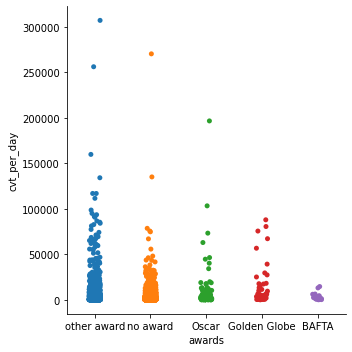

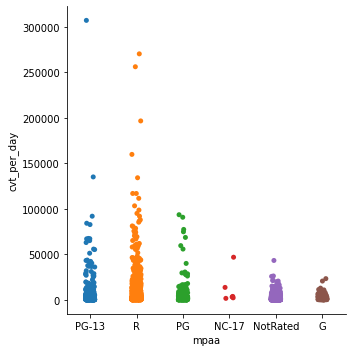

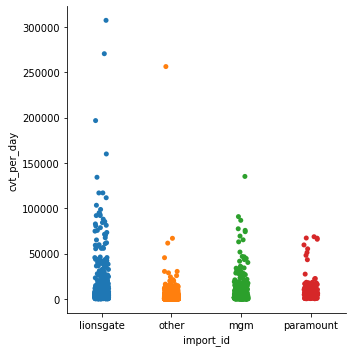

In [12]:
sns.catplot(x='awards',y='cvt_per_day',data=video)
print(video['awards'].value_counts()/video.shape[0])
sns.catplot(x='mpaa',y='cvt_per_day',data=video)
print(video['mpaa'].value_counts()/video.shape[0])
sns.catplot(x='import_id',y='cvt_per_day',data=video)
print(video['import_id'].value_counts()/video.shape[0])

This data vizulization outcome provides us some direct insights about chracteristics of the movies on Amazon Prime.

*   It seems that awards does not guarantee higher cvt_per_day 
*   R-rated and PG-13 are watched more than other ratings, which is possibly related to Amazon's target customer demographics.
* Among all the proudction companies, Amazon works closer with Lionsgate and licenses 16% of total videos to them.  




Number of distinct genres:  27
Action                    739
Adult                       3
Adventure                 363
Animation                 129
Anime                      11
Comedy                   1184
Crime                     437
Documentary               671
Drama                    1677
Fantasy                   243
Foreign/International      64
Holiday                     1
Horror                    762
Independent               393
Kids & Family             280
LGBT                        2
Lifestyle                   7
Music                     171
Musicals                   68
Mystery                   375
Reality                     9
Romance                   591
Sci-Fi                    363
Sport                      77
Thriller                  879
War                       102
Western                   102
dtype: int64


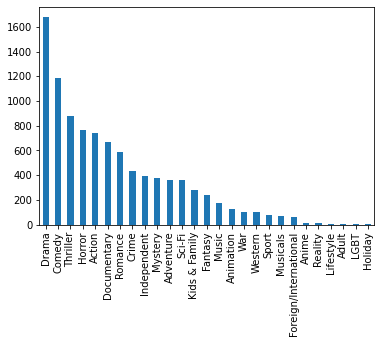

In [13]:
#seperate generes 
gen_split = video['genres'].str.get_dummies(sep=',').sum()
print('Number of distinct genres: ', (gen_split.shape[0]))
print(gen_split)

gen_split.sort_values(ascending=False).plot.bar()

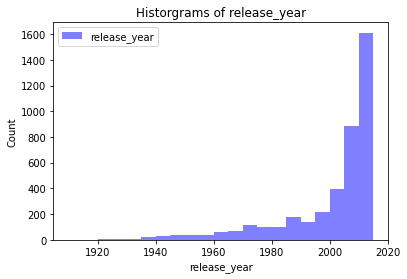

In [14]:
plt.hist(video['release_year'].values, bins = range(1910, 2017, 5), alpha = 0.5, color='b', label = 'release_year')
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year')
plt.xlabel('release_year')
plt.ylabel('Count')
plt.show()

In [0]:
# newvideo = pd.concat([video,video['genres'].str.split(',',expand=True)],axis=1)
# newvideo.loc[:,~newvideo.columns.duplicated()]
# newvideo.shape
# newvideo.columns

# Part 3 Feature Preprocessing

### 3.1 Categorical Feature Encoding

In [0]:
#encode first part of categorical features
categorical1 = ['import_id','awards','mpaa']
d_categorical1 = pd.get_dummies(video[categorical1],drop_first=True).astype(np.int64)

In [0]:
# Convert 'genres' into dummy variables
d_genres=video['genres'].str.get_dummies(sep=',').astype(np.int64)
d_genres['Misc_genres']=d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [0]:
# bin release_year and convert into dummies
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014, 2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']
year_bin = pd.cut(video['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [0]:
#create new dataframe with processed features
video_1 = video.drop(['import_id','awards','mpaa','genres','release_year'], axis =1)
video_2 = pd.concat([video_1, d_categorical1, d_genres, d_year], axis=1)

In [27]:
print(video_2.head())

   video_id  cvt_per_day  weighted_categorical_position  \
0    385504   307127.606                              1   
1    300175   270338.426                              1   
2    361899   256165.867                              1   
3    308314   196622.721                              3   
4    307201   159841.652                              1   

   weighted_horizontal_poition  imdb_votes    budget  boxoffice  imdb_rating  \
0                            3       69614  15000000   42930462        6.500   
1                            3       46705  15000000    3301046        6.500   
2                            3      197596  26000000   37397291        7.300   
3                            4      356339  15000000   15700000        7.600   
4                            3       46720  27220000    8551228        6.400   

   duration_in_mins  metacritic_score  star_category  import_id_mgm  \
0           112.301                51          1.710              0   
1            94.983   

### 3.2 Missing Value Imputation

#### From the results of EDA, there are six features containg missing values.
Feature | Missing Value Percentage
--- | ---
imdb_votes	|0.081
imdb_rating  |0.081
star_category |0.437
budget     |0.581
metacritic_score|0.713
boxoffice   |0.756

In [0]:
video_3 = video_2.copy()

In [0]:
# #mark value 0 as nan 
from numpy import nan
null_features = ['imdb_votes','budget','boxoffice','imdb_rating','star_category','metacritic_score']
video_3[null_features] = video_3[null_features].replace(0,nan) 

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=nan,strategy='mean')
video_3[null_features] = imputer.fit_transform(video_3[null_features])

In [32]:
video_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   imdb_votes                     4226 non-null   float64
 5   budget                         4226 non-null   float64
 6   boxoffice                      4226 non-null   float64
 7   imdb_rating                    4226 non-null   float64
 8   duration_in_mins               4226 non-null   float64
 9   metacritic_score               4226 non-null   float64
 10  star_category                  4226 non-null   float64
 11  import_id_mgm                  4226 non-null   int64  
 12  import_id_other                4226 non-null   i

### 3.3 Feature Scaling

Before training the model, we need to normalize numerical features to eliminate the impact of scales on modeling training results.

In [36]:
scale_features = ['weighted_categorical_position','weighted_horizontal_poition','budget','boxoffice', 
          'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score']
new_video = video_3.copy()

sc_scale = preprocessing.StandardScaler().fit(new_video[scale_features])


new_video[scale_features] = sc_scale.transform(new_video[scale_features])
new_video.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,import_id_mgm,import_id_other,import_id_paramount,awards_Golden Globe,awards_Oscar,awards_no award,awards_other award,mpaa_NC-17,mpaa_NotRated,mpaa_PG,mpaa_PG-13,mpaa_R,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_genres,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,-1.106,-2.116,1.984,1.470,4.696,0.542,1.079,-0.630,1.710,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,-1.106,-2.116,1.258,1.470,-1.022,0.542,0.257,-1.997,3.250,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,-1.106,-2.116,6.043,3.108,3.898,1.100,1.243,0.327,2.647,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,-0.780,-2.032,11.077,1.470,0.767,1.309,1.952,5.250,1.667,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,-1.106,-2.116,1.258,3.290,-0.265,0.472,0.758,-2.544,3.067,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


# Part 4 Modeling Training

### 4.1 Ranmdoly split 80% as training and 20% as testing data

In [0]:
train, test = train_test_split(new_video, test_size=0.20, random_state = 3)
model_train_x = train.drop(['cvt_per_day'], axis = 1)
model_test_x = test.drop(['cvt_per_day'], axis = 1)
model_train_y = train['cvt_per_day']
model_test_y = test['cvt_per_day']

In [39]:
print('training data has ' + str(model_train_x.shape[0]) + ' observation with ' + str(model_train_x.shape[1]) + ' features')
print('test data has ' + str(model_test_x.shape[0]) + ' observation with ' + str(model_test_x.shape[1]) + ' features')

training data has 3380 observation with 54 features
test data has 846 observation with 54 features


### 4.2 Lasso Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [0]:
lr_train, lr_validate = train_test_split(train, test_size = 0.25, random_state = 0)
lr_train_x = lr_train.drop(['cvt_per_day'],axis = 1)
lr_validate_x = lr_validate.drop(['cvt_per_day'],axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

alphas = np.logspace(-0.3, 2.5, num=150) #lambda 
scores = np.empty_like(alphas) 
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
  lasso = Lasso()
  lasso.set_params(alpha = a)
  lasso.fit(lr_train_x, lr_train_y)
  scores[i] = lasso.score(lr_validate_x, lr_validate_y) 
  if scores[i] > max_score:
    max_score = scores[i]
    opt_a = a
    lasso_save = lasso

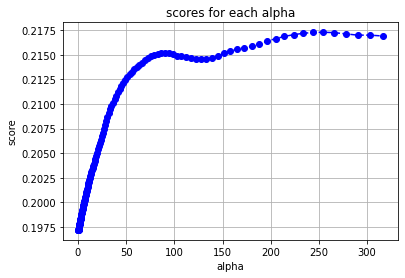

The optimaized alpha and score of Lasso linear is: 


(None, 254.70664095751977, 0.21730132161189364)

In [43]:
plt.plot(alphas, scores, color='b', linestyle='dashed',marker='o',markerfacecolor = 'blue',markersize =6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('scores for each alpha')
plt.show()
model1_para = opt_a
print ('The optimaized alpha and score of Lasso linear is: '), opt_a, max_score

In [44]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)

Lasso(alpha=254.70664095751977, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## 4.3 Ridge linear regression

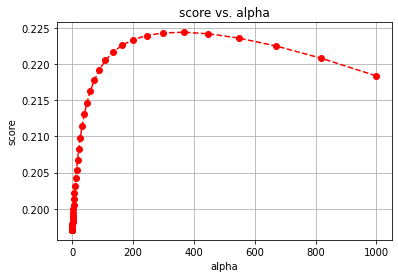

The optimaized alpha and score of Ridge linear is: 


(None, 366.2337713903369, 0.224418736524166)

In [45]:
# Use the same training data set as Lasso (linear features)
lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)

alphas = np.logspace (-10, 3, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model3_para = opt_a
print ('The optimaized alpha and score of Ridge linear is: '), opt_a, max_score

In [46]:
# add the 15% validate data, use the optimal alpha, re-train the model

ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

# ridge_f is the Ridge model (linear feature), to be tested with test data.

Ridge(alpha=366.2337713903369, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

## 4.4 Random Forest

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=2, max_features='sqrt',n_jobs = -1)
param_grid={'n_estimators':[44,45,46,47,48,49,50,51],'max_depth':[19,20,21,22,23,24,25,26]} 
clf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,refit=True,n_jobs=-1,pre_dispatch='2*n_jobs')
clf.fit(model_train_x,model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

{'mean_fit_time': array([0.43561735, 0.41788669, 0.43949718, 0.43895721, 0.41757541,
       0.40727921, 0.45309381, 0.43831182, 0.33477759, 0.34056215,
       0.34337969, 0.34876423, 0.37778301, 0.401513  , 0.41366315,
       0.44316912, 0.33293462, 0.34330883, 0.34164462, 0.36221914,
       0.38313355, 0.39752345, 0.41357493, 0.4420486 , 0.3403995 ,
       0.34170575, 0.34878669, 0.37850714, 0.40127773, 0.42165785,
       0.44671392, 0.42120633, 0.41321201, 0.41766205, 0.43653188,
       0.43305116, 0.44349251, 0.3861445 , 0.40663638, 0.44210315,
       0.33887463, 0.35390329, 0.3715807 , 0.35795975, 0.40379524,
       0.44560828, 0.41111598, 0.43315377, 0.3420002 , 0.35236421,
       0.42465701, 0.43851433, 0.41419277, 0.43616467, 0.44056878,
       0.42177896, 0.41251502, 0.43607354, 0.43535399, 0.43814659,
       0.38716836, 0.40889068, 0.4414083 , 0.42772102]), 'std_fit_time': array([0.00426122, 0.03919212, 0.00084079, 0.01179847, 0.04864312,
       0.04228628, 0.03590824, 0.01165

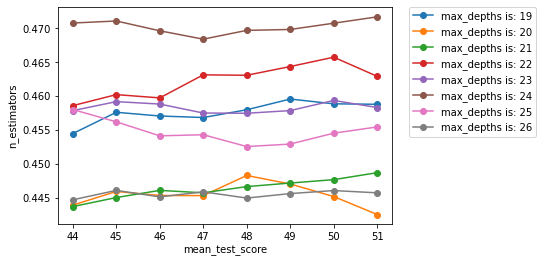

the best parameter for max_depth is: 24
the best parameter for n_estimators is: 51


In [65]:
result=clf.cv_results_
print(result)
max_depth=[19,20,21,22,23,24,25,26]
n_estimators=[44,45,46,47,48,49,50,51]
scores=clf.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators,scores[i],'-o',label='max_depths is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('mean_test_score')
plt.ylabel('n_estimators')
plt.show()
print('the best parameter for max_depth is: '+str(clf.best_params_['max_depth']))
print('the best parameter for n_estimators is: '+str(clf.best_params_['n_estimators']))

# Part 5 Model Evaluation

In [0]:
train_x = model_train_x
train_y = model_train_y
test_x = model_test_x
test_y = model_test_y

In [66]:
#For lasso
from sklearn.linear_model import Lasso
from sklearn.metrics import  mean_squared_error
lasso=Lasso(alpha=model1_para)
lasso.fit(train_x,train_y)
pred_y=lasso.predict(test_x)
lasso_score=lasso.score(test_x,test_y)
MSE_lasso=mean_squared_error(test_y,pred_y)
RMSE_lasso=np.sqrt(MSE_lasso)
print ('lasso score: ', lasso_score)
print ('Mean square error of lasso: ', MSE_lasso)
print ('Root mean squared error of lasso:', RMSE_lasso)

lasso score:  0.11429875594719996
Mean square error of lasso:  194075701.878322
Root mean squared error of lasso: 13931.105551187315


In [67]:
#for ridge
from sklearn.metrics import  mean_squared_error
ridge=Ridge(alpha=model3_para)
ridge.fit(train_x,train_y)
pred_y=ridge.predict(test_x)
ridge_score=ridge.score(test_x,test_y)
MSE_ridge=mean_squared_error(test_y,pred_y)
RMSE_ridge=np.sqrt(MSE_ridge)
print ('ridge score: ', ridge_score)
print ('Mean square error of ridge: ', MSE_ridge)
print ('Root mean squared error of ridge:', RMSE_ridge)

ridge score:  0.14259055997020598
Mean square error of ridge:  187876374.7801188
Root mean squared error of ridge: 13706.800311528537


In [68]:
#For randomforest regression
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'],max_depth=clf.best_params_['max_depth'],max_features='sqrt',random_state=2,n_jobs=-1)
rf.fit(train_x,train_y)
pred_y=rf.predict(test_x)
rf_score=rf.score(test_x,test_y)
MSE_rf=mean_squared_error(test_y,pred_y)
RMSE_rf=np.sqrt(MSE_rf)
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)

rf score:  0.5141781211083458
Mean square error of rf:  106453753.75370045
Root mean squared error of rf: 10317.642839025804


## 5.1 Model Comparision

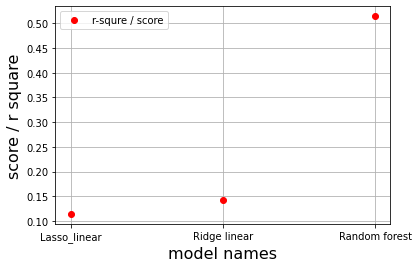

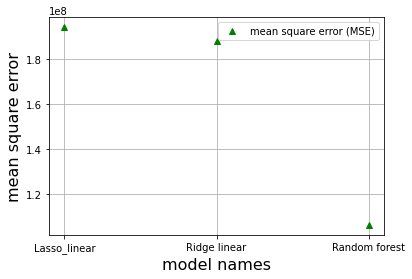

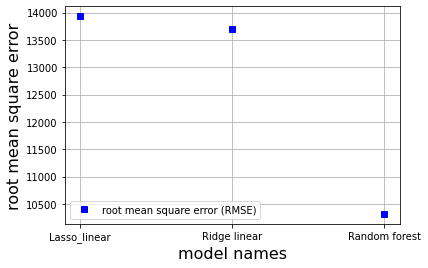

In [69]:
lst_score = [lasso_score, ridge_score, rf_score]
MSE_lst =  [MSE_lasso, MSE_ridge, MSE_rf]
RMSE_lst =  [RMSE_lasso, RMSE_ridge, RMSE_rf]
model_lst = ['Lasso_linear', 'Ridge linear', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

## 5.2 Feature Importance

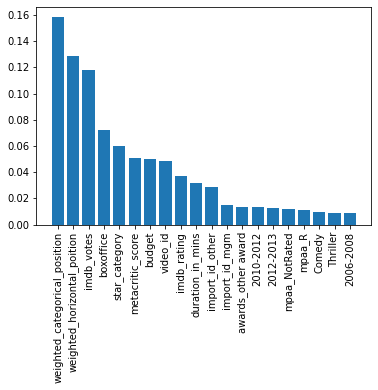

In [70]:
importances = rf.feature_importances_
feature_name = train_x.columns.values
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()

In [63]:
a = np.random.uniform(0.1,500,size = 350)
print(a)

[479.01652991 195.21098466 480.50321531 274.46150582 201.51431469
 249.67464496 434.33578015 401.29928401 146.30792936  51.62982002
 373.70632643 354.82570009 340.51766674 380.5492245  168.18532153
 315.08469865  24.508397   289.17461582 315.8419871  333.85591997
 346.64493954 102.32468915 318.57284744 277.21886791  15.71936784
 227.33552045 353.16120374 245.26786178   1.96347043 374.94342928
 444.96714282 431.19466618  84.13996248 298.60426669 310.71156679
 402.2068928  442.20127647  32.66691429 313.97413096  95.47125273
  54.88498638 287.10814449 418.19337503 450.30372063 345.97339359
 353.95980819 182.51630519 455.67444414  16.91753012 100.11819574
 128.4776962   79.75597577 288.58425113  63.74904203 248.06031525
 375.76427849 482.30597673  33.37550017  59.47762927 461.88142633
  98.7303863   32.22024826 145.81495529 260.66151878 426.81069735
 230.37017071 117.00046337  58.3991433  495.30400173 102.56401284
  12.77487295 171.88915659 112.56740775  33.1985543    6.50517247
  94.30467

In [64]:
a = np.logspace(-0.3, 2.5, num=150) #alphas here refers to lambda 
s = np.empty_like(alphas) 
print(a)
print(s)

[  0.50118723   0.52334966   0.54649211   0.57065791   0.59589232
   0.62224259   0.64975806   0.67849027   0.70849301   0.73982247
   0.77253731   0.8066988    0.8423709    0.87962042   0.9185171
   0.9591338    1.00154655   1.0458348    1.09208146   1.14037314
   1.19080027   1.24345729   1.29844279   1.35585974   1.41581566
   1.47842282   1.54379846   1.612065     1.68335028   1.75778779
   1.83551691   1.9166832    2.00143865   2.08994197   2.1823589
   2.27886249   2.37963346   2.48486051   2.59474067   2.70947973
   2.82929253   2.95440343   3.08504672   3.22146703   3.36391983
   3.51267188   3.66800172   3.83020022   3.99957111   4.17643156
   4.36111276   4.55396053   4.755336     4.96561626   5.18519508
   5.41448365   5.65391133   5.90392647   6.16499723   6.43761251
   6.72228279   7.01954116   7.32994424   7.65407331   7.99253531
   8.34596406   8.71502137   9.10039834   9.50281663   9.92302979
  10.36182472  10.8200231   11.29848294  11.79810021  12.31981048
  12.8645907